In [244]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [245]:
m = 5           # 5, 50, 100, 500, 2000

In [246]:
train_size = 500          # 100, 500, 2000, 10000

# Generate dataset

In [247]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [248]:
x = np.zeros((5000,2))

In [249]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [7,4],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [8,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [250]:
x[idx[0]][0], x[idx[5]][5] 

(array([7.14957125, 3.78451422]), array([0.87756167, 0.00457805]))

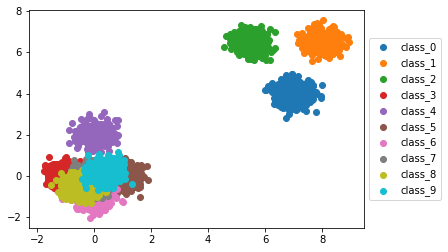

In [251]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [252]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [253]:
np.unique(bg_idx).shape

(3513,)

In [254]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [255]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[2.02981967, 1.63582644]]))

In [256]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [257]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[4.89756643, 3.00501566]]))

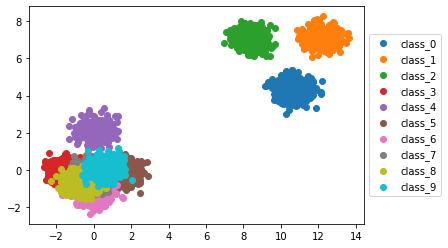

In [258]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [259]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [260]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)
train_data=[]
a = []
fg_instance = np.array([[0.0,0.0]])
bg_instance = np.array([[0.0,0.0]])

for i in range(m):
  if i == fg_idx:
    b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
    fg_instance += x[b]
    a.append(x[b])
    print("foreground "+str(fg_class)+" present at " + str(fg_idx))
  else:
    bg_class = np.random.randint(3,10)
    b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
    bg_instance += x[b]
    a.append(x[b])
    print("background "+str(bg_class)+" present at " + str(i))

a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
foreground 2 present at 2
background 5 present at 3
background 3 present at 4
(5, 2)
2 2


In [261]:
a

array([[ 1.52560273, -0.1298488 ],
       [-0.4226508 , -1.2003313 ],
       [ 8.5153438 ,  7.02349438],
       [ 2.09728368, -0.24465132],
       [-0.98608769, -0.75123246]])

In [262]:
fg_instance

array([[8.5153438 , 7.02349438]])

In [263]:
bg_instance

array([[ 2.21414792, -2.32606388]])

In [264]:
(fg_instance+bg_instance)/m , m

(array([[2.14589834, 0.9394861 ]]), 5)

In [265]:
np.reshape(a,(2*m,1))

array([[ 1.52560273],
       [-0.1298488 ],
       [-0.4226508 ],
       [-1.2003313 ],
       [ 8.5153438 ],
       [ 7.02349438],
       [ 2.09728368],
       [-0.24465132],
       [-0.98608769],
       [-0.75123246]])

In [266]:
# mosaic_list_of_images =[]
# mosaic_label = []
train_label=[]
fore_idx=[]
train_data = []
for j in range(train_size):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  bg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  # a=[]

  for i in range(m):
    if i == fg_idx:
      fg_class  = np.random.randint(0,3)
      b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
      fg_instance += x[b]
      # a.append(x[b])
      # print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
      bg_class = np.random.randint(3,10)
      b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
      bg_instance += x[b]
      # a.append(x[b])
      # print("background "+str(bg_class)+" present at " + str(i))
  train_data.append((fg_instance+bg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  train_label.append(fg_class)
  fore_idx.append(fg_idx)

In [267]:
 train_data[0], train_label[0]

(tensor([[2.5500, 1.2844]], dtype=torch.float64), 1)

In [268]:
train_data = torch.stack(train_data, axis=0)
train_data.shape, len(train_label)

(torch.Size([500, 1, 2]), 500)

In [269]:
test_label=[]
# fore_idx=[]
test_data = []
for j in range(1000):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])

  fg_class  = np.random.randint(0,3)
  b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
  fg_instance += x[b]
  # a.append(x[b])
  # print("foreground "+str(fg_class)+" present at " + str(fg_idx))

  test_data.append((fg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  test_label.append(fg_class)
  # fore_idx.append(fg_idx)

In [270]:
test_data[0], test_label[0]

(tensor([[2.2281, 0.7835]], dtype=torch.float64), 0)

In [271]:
test_data = torch.stack(test_data, axis=0)
test_data.shape, len(test_label)

(torch.Size([1000, 1, 2]), 1000)

In [272]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

In [273]:
x1[y1==0,0]

array([[ 2.91933715,  1.0741029 ],
       [ 3.16467411,  0.60167476],
       [ 2.6630971 ,  1.06327091],
       [ 2.31375845,  1.55341058],
       [ 2.14881535,  0.3181068 ],
       [ 1.98370705,  0.89389841],
       [ 2.05611571,  0.95916786],
       [ 2.14642057,  0.92390365],
       [ 2.4293389 ,  0.80424024],
       [ 1.97338782,  0.95192091],
       [ 1.75458171,  0.46575381],
       [ 2.4901346 ,  0.96316251],
       [ 2.12813713,  1.24769929],
       [ 2.1262188 ,  1.89611777],
       [ 1.97339493,  1.65427581],
       [ 2.51664415,  0.92664266],
       [ 2.29987379,  0.29510293],
       [ 1.86295681,  0.55084773],
       [ 1.55161045,  0.68188311],
       [ 2.04884425,  2.02487939],
       [ 2.28713336,  1.32235473],
       [ 1.85230616,  1.58192551],
       [ 1.81925273,  1.39182937],
       [ 2.46404253,  0.56864595],
       [ 2.0712841 ,  0.68494438],
       [ 2.33811444,  0.65280382],
       [ 2.36798671,  0.65919216],
       [ 2.42726997,  1.06608924],
       [ 1.76566593,

In [274]:
x1[y1==0,0][:,0]

array([2.91933715, 3.16467411, 2.6630971 , 2.31375845, 2.14881535,
       1.98370705, 2.05611571, 2.14642057, 2.4293389 , 1.97338782,
       1.75458171, 2.4901346 , 2.12813713, 2.1262188 , 1.97339493,
       2.51664415, 2.29987379, 1.86295681, 1.55161045, 2.04884425,
       2.28713336, 1.85230616, 1.81925273, 2.46404253, 2.0712841 ,
       2.33811444, 2.36798671, 2.42726997, 1.76566593, 2.03202497,
       2.18565533, 2.13780976, 2.27163287, 2.17498771, 2.99417873,
       2.31621034, 1.65132905, 2.44413804, 2.44545175, 2.17044804,
       1.88359119, 1.83735384, 2.85287233, 2.78301702, 1.30840133,
       2.55647387, 3.23253834, 2.45375263, 2.71691103, 2.31617501,
       2.18798007, 1.94065718, 2.38721081, 1.72873715, 2.2076117 ,
       1.78178069, 2.23915419, 1.64970475, 2.16272317, 2.1318918 ,
       1.79814878, 1.26981837, 2.30872451, 1.4814616 , 2.72108231,
       2.97163958, 1.65944029, 2.12650431, 1.95042376, 2.07147887,
       2.10257903, 2.00508289, 2.2017309 , 2.92510859, 2.33110

In [275]:
x1[y1==0,0][:,1]

array([ 1.0741029 ,  0.60167476,  1.06327091,  1.55341058,  0.3181068 ,
        0.89389841,  0.95916786,  0.92390365,  0.80424024,  0.95192091,
        0.46575381,  0.96316251,  1.24769929,  1.89611777,  1.65427581,
        0.92664266,  0.29510293,  0.55084773,  0.68188311,  2.02487939,
        1.32235473,  1.58192551,  1.39182937,  0.56864595,  0.68494438,
        0.65280382,  0.65919216,  1.06608924,  0.95751089,  0.14032099,
        1.06047517,  0.51610297,  1.41559426,  1.00739184,  0.36207472,
        0.66045599,  1.01439929,  1.1417045 ,  0.99110649,  0.62762646,
        0.75489767,  0.52533793,  0.8499182 ,  1.60051607,  1.00083542,
        0.73102786,  0.98401819,  1.32566642,  1.60186749,  0.96901257,
        1.02956104,  0.50555735,  0.95345094,  1.85794859,  0.62739849,
        1.01644857,  1.32895551,  0.84851677,  1.29185116,  0.75750295,
        1.57345662,  1.14793439,  0.92088126,  1.32966822,  0.4834489 ,
        0.94161355,  0.86099901,  1.40452653,  1.11638966,  1.65

Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/5')

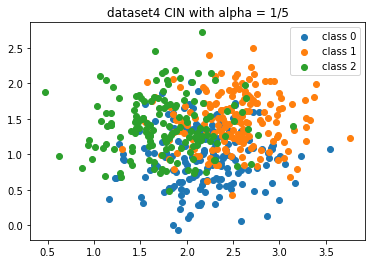

In [276]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

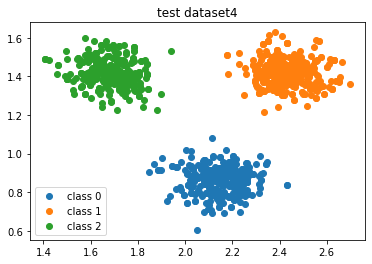

In [277]:
x1 = (test_data).numpy()
y1 = np.array(test_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [278]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [279]:
train_data[0].shape, train_data[0]

(torch.Size([1, 2]), tensor([[2.5500, 1.2844]], dtype=torch.float64))

In [280]:
batch = 200

traindata_1 = MosaicDataset(train_data, train_label )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [281]:
testdata_1 = MosaicDataset(test_data, test_label )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [282]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [283]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,50)
        self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = (self.linear2(x))

        return x[:,0]

In [284]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      # print(outputs.shape)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [285]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [286]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs.shape)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [287]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [288]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.077
epoch: [1] loss: 1.066
epoch: [201] loss: 0.760
epoch: [401] loss: 0.750
epoch: [601] loss: 0.750
epoch: [801] loss: 0.736
Finished Training
Accuracy of the network on the 500 train images: 65.80 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  1000 total  1000
Accuracy of the network on the 1000 test dataset 1: 100.00 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.077
epoch: [1] loss: 1.066
epoch: [201] loss: 0.760
epoch: [401] loss: 0.750
epoch: [601] loss: 0.750
epoch: [801] loss: 0.736
Finished Training
Accuracy of the network on the 500 train images: 65.80 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  1000 total  1000
Accuracy of the network on the 1000 test dataset 1: 100.00 %
-------------------------------------------------------------------------

In [289]:
%matplotlib inline

In [290]:
len(fin_loss)

8

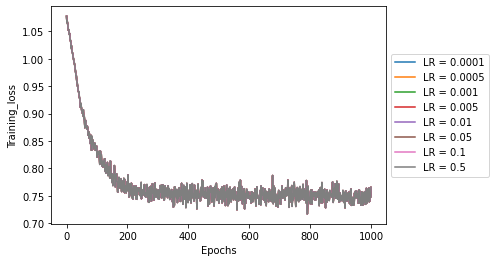

In [291]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))